In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [2]:
df = pd.read_csv("C:/Users/munic/Downloads/ecommerce_data.csv")

In [3]:
df['TotalSpent'] = df['OrderCount'] * df['AverageOrderValue']
df['Recency'] = (pd.to_datetime('2025-08-01') - pd.to_datetime(df['LastPurchaseDate'])).dt.days

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = [word for word in text.split() if word not in stop]
    return " ".join(tokens)

df['CleanedFeedback'] = df['Feedback'].fillna('').apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\munic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['CleanedFeedback'])

nmf = NMF(n_components=5, random_state=42)
topic_features = nmf.fit_transform(X_tfidf)


for i in range(topic_features.shape[1]):
    df[f"Topic_{i}"] = topic_features[:, i]

In [6]:
features = ['Recency', 'OrderCount', 'TotalSpent', 'SessionTime', 'BounceRate'] + [f"Topic_{i}" for i in range(5)]
X = df[features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [7]:
sse = []
sil_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

C:\Users\munic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\munic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\munic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\munic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

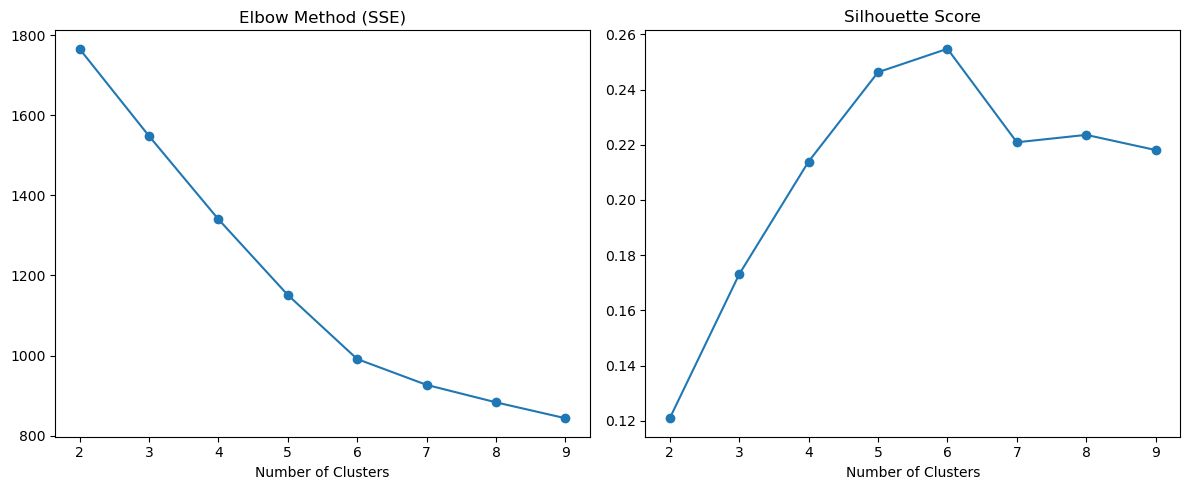

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), sse, marker='o')
plt.title('Elbow Method (SSE)')
plt.xlabel('Number of Clusters')

plt.subplot(1, 2, 2)
plt.plot(range(2, 10), sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.tight_layout()
plt.show()


In [9]:
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(X_scaled)
df['Segment'] = kmeans.labels_

C:\Users\munic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\munic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [10]:
segment_summary = df.groupby('Segment')[features].mean()
print("\nSegment Summary:")
print(segment_summary)


Segment Summary:
            Recency  OrderCount   TotalSpent  SessionTime  BounceRate  \
Segment                                                                 
0        186.875000    9.708333  2383.907500    15.885417   58.015833   
1        217.150000   10.125000  2285.552250    16.346500   53.301750   
2        185.205128    9.837607  2350.153675    16.468034   50.783761   
3        166.210526   10.789474  2782.801053    16.781579   42.733684   

          Topic_0   Topic_1   Topic_2   Topic_3   Topic_4  
Segment                                                    
0        0.000000  0.422358  0.000000  0.000000  0.000000  
1        0.319251  0.000000  0.000000  0.000000  0.000000  
2        0.000000  0.000000  0.085548  0.109919  0.008246  
3        0.000000  0.000000  0.000000  0.000000  0.515163  


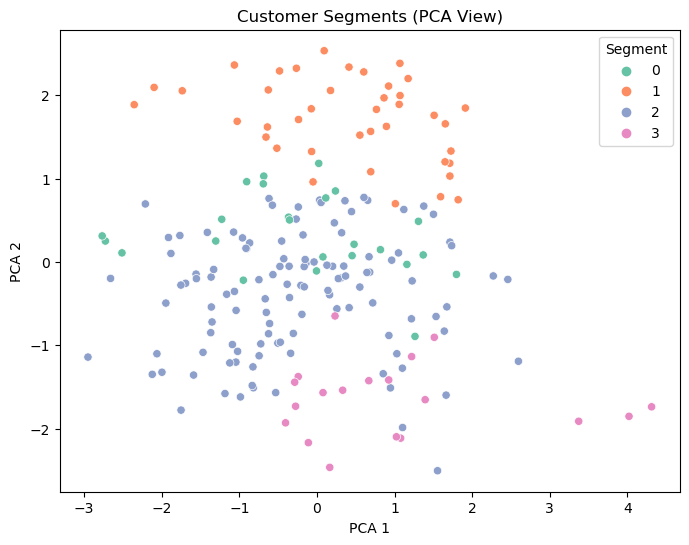

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Segment'], palette='Set2')
plt.title("Customer Segments (PCA View)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()